## Load the ECG dataset

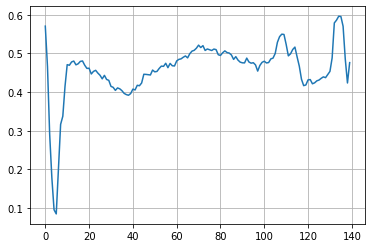

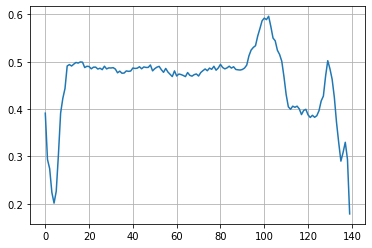

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Activation

# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(140), train_data[0])
plt.show()

plt.grid()
plt.plot(np.arange(140), train_data[100])
plt.show()

# Set up the model

In [53]:
# The input size/image
input_img = keras.Input(shape=(140,))
# The size of latent space
encoding_dim = 64
## Add a simple encode layer
# encoded = keras.layers.Dense(encoding_dim, activation='relu')(input_img)
# You can add encode layer with a L1 activity regularizer
encoded = keras.layers.Dense(encoding_dim, activation='relu', 
                activity_regularizer=keras.regularizers.l1(10e-5))(input_img)
# Add decode layer
decoded = keras.layers.Dense(140, activation='sigmoid')(encoded)

# Claim autoencoder model
model_autoencoder = keras.Model(input_img, decoded)

# Claim a separate encoder model
model_encoder = keras.Model(input_img, encoded)

# Claim a separate decoder model
decoder_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = model_autoencoder.layers[-1]
# Create the decoder model
model_decoder = keras.Model(decoder_input, decoder_layer(decoder_input))

# Training

Epoch 1/30
250/250 [==============================] - 1s 2ms/step - loss: 0.6889 - val_loss: 0.6821
Epoch 2/30
250/250 [==============================] - 0s 2ms/step - loss: 0.6816 - val_loss: 0.6811
Epoch 3/30
250/250 [==============================] - 0s 2ms/step - loss: 0.6809 - val_loss: 0.6805
Epoch 4/30
250/250 [==============================] - 0s 2ms/step - loss: 0.6804 - val_loss: 0.6802
Epoch 5/30
250/250 [==============================] - 0s 2ms/step - loss: 0.6802 - val_loss: 0.6800
Epoch 6/30
250/250 [==============================] - 0s 2ms/step - loss: 0.6800 - val_loss: 0.6799
Epoch 7/30
250/250 [==============================] - 0s 2ms/step - loss: 0.6798 - val_loss: 0.6797
Epoch 8/30
250/250 [==============================] - 0s 2ms/step - loss: 0.6797 - val_loss: 0.6796
Epoch 9/30
250/250 [==============================] - 0s 2ms/step - loss: 0.6796 - val_loss: 0.6795
Epoch 10/30
250/250 [==============================] - 0s 2ms/step - loss: 0.6796 - val_loss: 0.6795

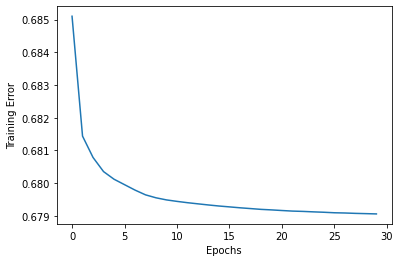

In [54]:
# Claim compile property for training
model_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder model
hist=model_autoencoder.fit(train_data, train_data,
                epochs=30,
                batch_size=16,
                shuffle=True,
                validation_data=(test_data, test_data))

plt.plot(hist.history["loss"]);
plt.xlabel('Epochs');
plt.ylabel('Training Error');

## Supervised Classification with AEs

In [55]:
model = keras.Sequential()
model.add(model_encoder.layers[0])
model.add(model_encoder.layers[1])
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
one_hot_labels = keras.utils.to_categorical(train_labels, num_classes=2)

# Train the model, iterating on the data in batches of 32 samples
model.fit(train_data, one_hot_labels, epochs=10, batch_size=32)

y_pred=np.argmax(model.predict(test_data), axis=1)
print(f1_score(test_labels, y_pred, average="macro"))
print(precision_score(test_labels, y_pred, average="macro"))
print(recall_score(test_labels, y_pred, average="macro"))

Epoch 1/10
125/125 [==============================] - 1s 1ms/step - loss: 0.1767 - accuracy: 0.8456
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0754 - accuracy: 0.9461
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0436 - accuracy: 0.9581
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0372 - accuracy: 0.9528
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 0.9589
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0256 - accuracy: 0.9710
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0232 - accuracy: 0.9724
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0226 - accuracy: 0.9744
Epoch 9/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0171 - accuracy: 0.9829
Epoch 10/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0202 - accuracy: 0.9753